In [1]:
# load libraries
library(dplyr)
library("edgeR")
library(Matrix)
library(gplots)
library(RColorBrewer)
library(irlba)
library(proxy)
library(png)
library(tidyverse)
library(ComplexHeatmap)
library(here)
library(preprocessCore)
library(circlize)
`%ni%` <- Negate(`%in%`)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0.9000     ✔ readr     2.1.4     
✔ ggplot2   3.4.3          ✔ stringr   1.5.0     
✔ lubridate 1.9.2          ✔ tibble    3.2.1     
✔ purrr     1.0.2          ✔ tidyr     1.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() m

In [2]:
get_CPM_values <- function(input, meta, cell_annot_alot){
  
  meta_data <- read.delim(meta) %>% 
        rename(cell_type = !!sym(cell_annot_alot)) 
    
    
  raw_cpm_counts_all_genes <- read_delim(input, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
    dplyr::mutate(cellID = barcode)  %>%
    dplyr::mutate(geneID = gene_name)
    
  merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    group_by(cell_type, geneID)  %>%
    summarise(counts = sum(accessability, na.rm = TRUE))

  ### Alt CPM Calc
  merged_meta_cpm_information_copied <- merged_meta_cpm_information
  catch <- merged_meta_cpm_information_copied  %>%
    group_by(cell_type) %>%
    group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
    unlist()

  caught_values <- as_tibble(catch)
  #see <- ungroup(merged_meta_cpm_information_copied)
  merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, caught_values)  %>% 
    rename(grouped_CPM = value)
    
    
  quantile_normalized_values <- merged_meta_cpm_information_copied %>% 
        group_by(cell_type) %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

    
    
  quantile_normalized <- as_tibble(quantile_normalized_values)  %>% 
        dplyr::rename("quant_norm_cpm" = value)


  quantile_normalized_data <- bind_cols(merged_meta_cpm_information_copied, quantile_normalized) %>% 
        group_by(geneID)
        #dplyr::mutate(Zscore = scale(quant_norm_cpm))



  return(quantile_normalized_data)
}



In [3]:
generate_matrix_for_heatmap <- function(cell_type_by_gene_by_quant_norm, markers) {
    
    
    mat <- cell_type_by_gene_by_quant_norm %>%
        dplyr::filter(cell_type %in% c("mesophyll", "bundle_sheath")) %>% 
        dplyr::filter(geneID %in% markers$geneID) %>% 
        left_join(., markers, by = c("geneID")) %>% 
        dplyr::ungroup() %>%   
        dplyr::select(cell_type, name, quant_norm_cpm) %>% 
        pivot_wider(names_from = cell_type, values_from = quant_norm_cpm) %>% 
        dplyr::rowwise() %>% 
        dplyr::mutate(log2_val = log2(bundle_sheath/mesophyll)) %>% 
        dplyr::select(name, log2_val) 
}

In [4]:
output_location <- "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_2/heatmaps/"

In [5]:
uf_gene_activity <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/urochloa_fusca/acc_metrics_leaf_clustering/urochloa_fusca.gene_body_acc_leaf_clustering.counts.txt"
uf_meta <- "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/uf_annot/uf.leaf_annotation.V1.meta.txt"
uf_marker_genes <- read_delim("/home/jpm73279/genome_downloads/C4_markers/Uf.c4_markers.bed", delim = "\t", col_names = c("chrom", "start", "stop", "geneID", "name", "type"))


Rows: 31 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): chrom, geneID, name, type, X7
dbl (2): start, stop

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
uf_cpm_values <- get_CPM_values(uf_gene_activity, uf_meta, "annotation_v1")

Rows: 73649352 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'cell_type'. You can override using the
`.groups` argument.


In [7]:
uf_C4_matrix <- generate_matrix_for_heatmap(uf_cpm_values, uf_marker_genes)

In [8]:
uf_C4_matrix.df <- data.frame(uf_C4_matrix, row.names = 1)

In [9]:
# Function definition
filter_tribble_by_name <- function(data, names) {
  updated <- data %>%
    filter(name %in% names)
    
    updated <- data.frame(updated, row.names = 1)
    return(updated)
}


# Generate Core C4 Gene Heatmaps

In [12]:
col_fun <- colorRamp2(c(-2, 0, 2), c("red", "white", "blue"))


generate_split_heatmap <- function(log2matrix, df_marker_type) {
    
     updated <- log2matrix %>%
        filter(name %in% df_marker_type$name) %>% 
        left_join(.,df_marker_type, by = c("name")) %>% 
        dplyr::ungroup() %>% 
        dplyr::group_by(cell_type) %>% 
        dplyr::arrange(desc(log2_val), .by_group = TRUE) %>% 
        mutate(name = str_replace_all(name, "_ortho_count_", "_"))


    return(updated)
    
}

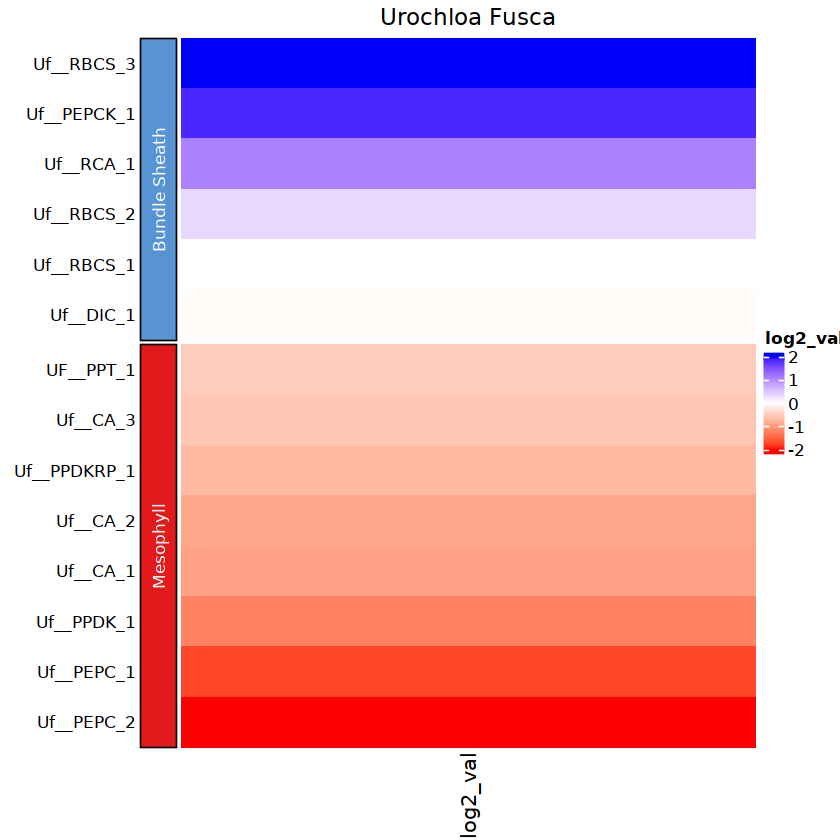

In [13]:
uf_marker_name_type <- data.frame(
  name = c("Uf__CA_3", "Uf__CA_1", "Uf__CA_2", "Uf__DIC_1", "Uf__PEPC_1", "Uf__PEPC_2", 
           "Uf__PEPCK_1", "Uf__PPDK_1", "Uf__PPDKRP_1", "UF__PPT_1", "Uf__RBCS_1", 
           "Uf__RBCS_2", "Uf__RBCS_3", "Uf__RCA_1"),
  cell_type = c("Mesophyll", "Mesophyll", "Mesophyll", "Bundle Sheath", "Mesophyll", 
                "Mesophyll", "Bundle Sheath", "Mesophyll", "Mesophyll", "Mesophyll", 
                "Bundle Sheath", "Bundle Sheath", "Bundle Sheath", "Bundle Sheath")
)


#uf_marker_name_type <- data.frame(name = names(uf_annot_markers), cell_type = unname(uf_annot_markers))

uf_data_merged <- generate_split_heatmap(uf_C4_matrix, uf_marker_name_type)

uf_generate_matrix <- as.matrix(uf_data_merged[,"log2_val"])
rownames(uf_generate_matrix) <- uf_data_merged$name

# create heatmap
uf_heatmap <- Heatmap(uf_generate_matrix, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = uf_data_merged$cell_type,
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   #row_title = "Gene",
                   row_title = NULL,
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4", "#E31A1C")),
                        labels = unique(uf_data_merged$cell_type), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Urochloa Fusca",
                   row_title_gp = gpar(fontsize = 14))

uf_heatmap
#draw(heatmap)

# Generate heatmap for Subtypes

In [16]:

uf_annot_markers_subtype <- data.frame(
  name = c("Uf__NADMDH_1", "Uf__AlaAT_1", "Uf__AlaAT_2", "Uf__AlaAT_3", "Uf__AlaAT_4",
           "Uf__ASPAT_1", "Uf__ASPAT_2", "Uf__BASS_1", "Uf__DIT_1", "Uf__DIT_2",
           "Uf__NADPMDH_1", "Uf__NADPME_1", "Uf__NHD_1", "Uf__PEPCK_1",
           "Uf__NADME_1", "Uf__NADME_2", "Uf__BASS_2"),
  cell_type = c("Mesophyll", "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", 
                "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath",
                "Mesophyll, Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll", 
                "Mesophyll", "Bundle Sheath", "Mesophyll",
                "Mesophyll, Bundle Sheath", "Mesophyll", "Bundle Sheath",
                "Bundle Sheath", "Bundle Sheath","Mesophyll")
)

# Assuming your data frame is named df
uf_annot_markers_subtype$cell_type <- as.factor(uf_annot_markers_subtype$cell_type)
uf_annot_markers_subtype$cell_type <- factor(uf_annot_markers_subtype$cell_type, levels = c("Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll"))    
uf_annot_markers_subtype <-  uf_annot_markers_subtype %>% 
    arrange(cell_type)

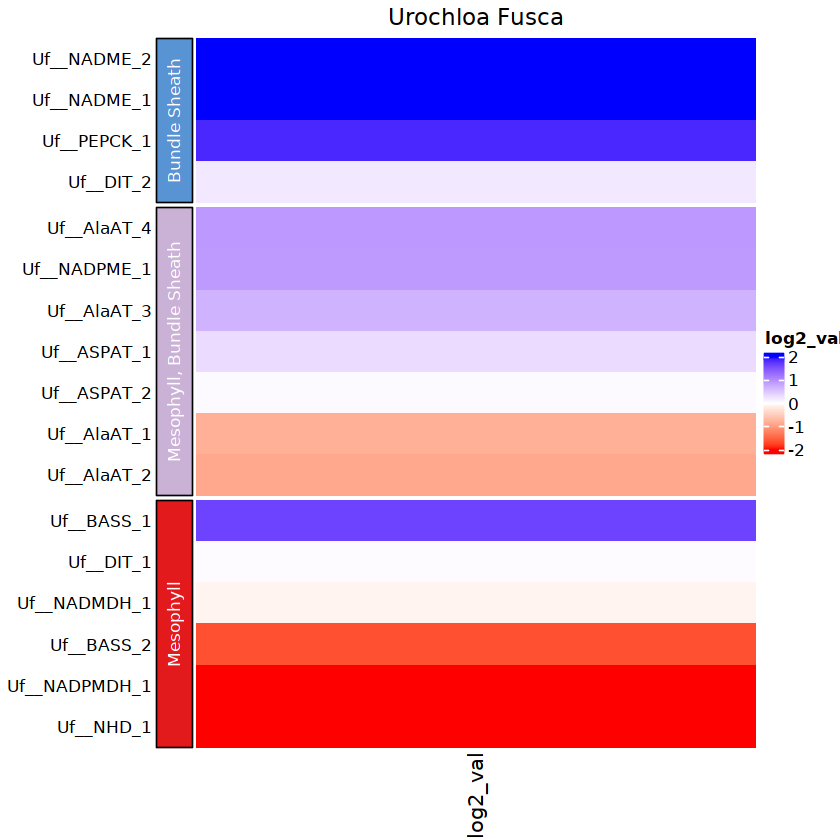

In [17]:
uf_data_merged_subtype <- generate_split_heatmap(uf_C4_matrix, uf_annot_markers_subtype)
uf_generate_matrix_subtype <- as.matrix(uf_data_merged_subtype[,"log2_val"])
rownames(uf_generate_matrix_subtype) <- uf_data_merged_subtype$name

# create heatmap
uf_heatmap_subtype <- Heatmap(uf_generate_matrix_subtype, name = "log2_val",
                   col = col_fun,
                   row_names_gp = gpar(fontsize = 10),
                   split = factor(uf_annot_markers_subtype$cell_type, levels = c("Bundle Sheath", "Mesophyll, Bundle Sheath", "Mesophyll")),
                    row_names_side = "left",
                   show_row_names = TRUE,
                   cluster_rows = FALSE,
                   #row_title = "Gene",
                   row_title = NULL,
                   row_title_side = "left",
                    left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = c("#5894D4","#CAB2D6", "#E31A1C")),
                        labels = unique((uf_annot_markers_subtype$cell_type)), 
                        labels_gp = gpar(col = "white", fontsize = 10))),  
                     column_title = "Urochloa Fusca",
                   row_title_gp = gpar(fontsize = 14))

uf_heatmap_subtype
#draw(heatmap)

In [18]:
uf_data_merged_subtype

name,log2_val,cell_type
<chr>,<dbl>,<fct>
Uf__NADME_2,4.33433141,Bundle Sheath
Uf__NADME_1,3.32110751,Bundle Sheath
Uf__PEPCK_1,1.82619809,Bundle Sheath
Uf__DIT_2,0.19475463,Bundle Sheath
Uf__AlaAT_4,0.88286713,"Mesophyll, Bundle Sheath"
Uf__NADPME_1,0.87182632,"Mesophyll, Bundle Sheath"
Uf__AlaAT_3,0.65470185,"Mesophyll, Bundle Sheath"
Uf__ASPAT_1,0.29620064,"Mesophyll, Bundle Sheath"
Uf__ASPAT_2,0.05245264,"Mesophyll, Bundle Sheath"


In [19]:
output_function <- function(output_place, heatmap, name) {
    file_name <- paste0(output_place, name)
    pdf(file = file_name, height = 6, width = 4)
    draw(heatmap)
    dev.off()
}

In [20]:
output_function(output_location, uf_heatmap, "uf_core_c4_genes.pdf")
output_function(output_location, uf_heatmap_subtype, "uf_variable_c4_genes.pdf")

png 
  2

png 
  2